# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2025-08-02 13:17:09.209355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754140629.588219      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754140629.698102      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Set Random Seeds

In [3]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds(42)

# Load Dataset

In [4]:
import cv2

dataset_dir = "/kaggle/input/garbage-classification-v2/garbage-dataset"

image_paths = []
labels = []

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image_paths.append(img_path)
            labels.append(class_name)      # this code to convert the data in the folder to be list to add it in csv files


df = pd.DataFrame({"path": image_paths, "label": labels}) # to create dataframe

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42) #split data to be training data and valid data

train_df.to_csv("train.csv", index=False) #create csv file for training data
val_df.to_csv("val.csv", index=False) #create csv file to valid data


le = LabelEncoder()
train_labels_enc = le.fit_transform(train_df["label"]) #encoding labels of classes 
val_labels_enc = le.transform(val_df["label"])

train_labels_cat = to_categorical(train_labels_enc, num_classes=10)
val_labels_cat = to_categorical(val_labels_enc, num_classes=10)  


def preprocess_images_cv2(image_paths, img_size=(224, 224)):
    images = []
    for path in image_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError("الصورة غير صالحة")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from RGB to BGR
            img = cv2.resize(img, img_size)  #resize the image (224,224)
            img = img.astype(np.float32) / 255.0  #normalize values
            images.append(img)
        except Exception as e:
            print(f" خطأ في الصورة: {path} -- {e}")
    return np.array(images)

train_images = preprocess_images_cv2(train_df["path"].tolist())
val_images = preprocess_images_cv2(val_df["path"].tolist())

In [5]:
train_df.head()

,path,label
7383,/kaggle/input/garbage-classification-v2/garbag...,battery
729,/kaggle/input/garbage-classification-v2/garbag...,metal
11556,/kaggle/input/garbage-classification-v2/garbag...,shoes
6763,/kaggle/input/garbage-classification-v2/garbag...,battery
17431,/kaggle/input/garbage-classification-v2/garbag...,clothes


# Visualizing Data

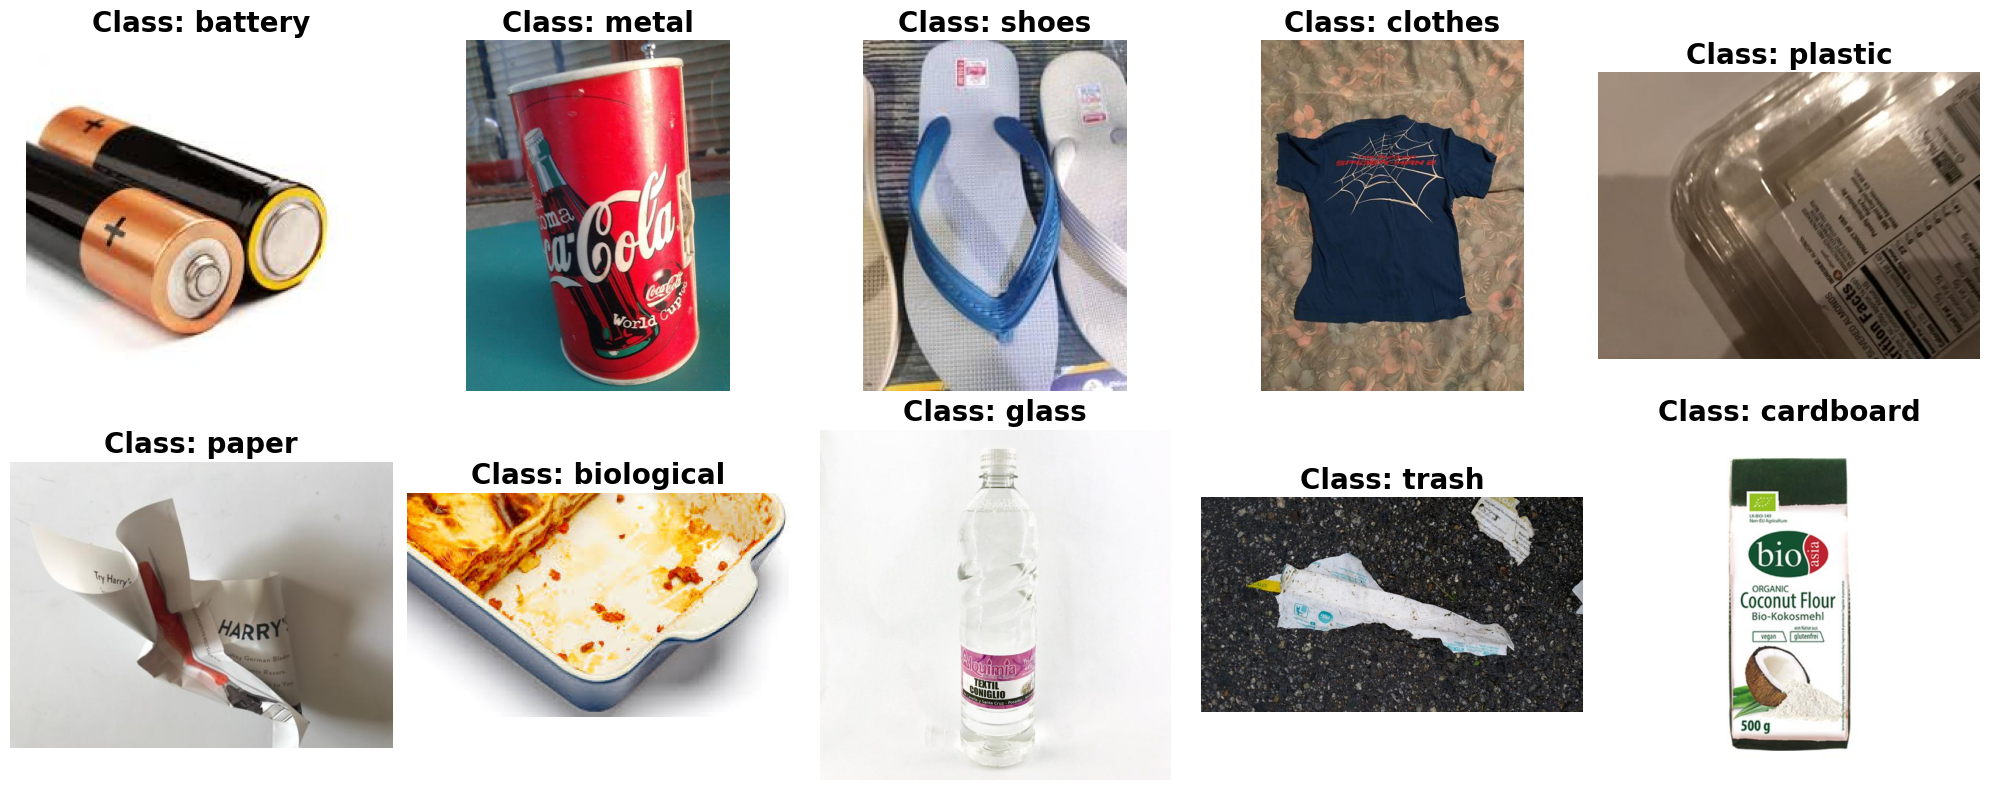

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
axes = axes.ravel()

classes = train_df['label'].unique()

for i, cls in enumerate(classes[:10]):  
    sample_file = train_df[train_df['label'] == cls].sample(n=7)['path'].values[0]
    
    img = Image.open(sample_file)
    
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {cls}', fontdict={'fontsize': 20, 'fontweight': 'bold'})
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(
    train_images, train_labels_cat, batch_size=32, shuffle=True
)

val_generator = ImageDataGenerator().flow(
    val_images, val_labels_cat, batch_size=32, shuffle=False
)

# Importing MobileNet

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout

In [9]:
#import
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Freeze base layers
base_model.trainable = False

I0000 00:00:1754140918.350190      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754140918.350931      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
#Custom model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax')(x)

#Full model

model = Model(inputs=base_model.input, outputs=x)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=3,
    min_lr=1e-6
)
callbacks = [early_stopping , reduce_lr]
batch_size = 32
epochs = 20
history = model.fit(
    train_generator,
    validation_data=(val_images, val_labels_cat),
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [early_stopping , reduce_lr],
    verbose=1
)


Epoch 1/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 170s 321ms/step - accuracy: 0.4727 - loss: 1.6079 - val_accuracy: 0.8411 - val_loss: 0.4966 - learning_rate: 1.0000e-04
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 144s 291ms/step - accuracy: 0.7870 - loss: 0.6579 - val_accuracy: 0.8834 - val_loss: 0.3712 - learning_rate: 1.0000e-04
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 148s 298ms/step - accuracy: 0.8401 - loss: 0.4992 - val_accuracy: 0.8950 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 4/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 145s 292ms/step - accuracy: 0.8641 - loss: 0.4196 - val_accuracy: 0.9008 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 5/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 147s 298ms/step - accuracy: 0.8793 - loss: 0.3763 - val_accuracy: 0.9115 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 6/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 145s 293ms/step - accuracy: 0.8906 - loss: 0.3473 - val_accuracy: 0.9137 - val_loss: 0.2654 - learning_rate: 1.0000e-04
Epoch 7/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 

# Fine-Tuning

In [23]:
# فتح آخر 5 طبقات فقط للتدريب (Fine-Tuning)
for layer in base_model.layers[-5:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    datagen.flow(train_images, train_labels_cat, batch_size=16),
    validation_data=(val_images, val_labels_cat),
    epochs=8,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 175s 163ms/step - accuracy: 0.9173 - loss: 0.2510 - val_accuracy: 0.9330 - val_loss: 0.2153 - learning_rate: 1.0000e-05
Epoch 2/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 149ms/step - accuracy: 0.9267 - loss: 0.2280 - val_accuracy: 0.9342 - val_loss: 0.2178 - learning_rate: 1.0000e-05
Epoch 3/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 146s 148ms/step - accuracy: 0.9295 - loss: 0.2172 - val_accuracy: 0.9342 - val_loss: 0.2107 - learning_rate: 1.0000e-05
Epoch 4/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 150ms/step - accuracy: 0.9337 - loss: 0.2124 - val_accuracy: 0.9373 - val_loss: 0.2032 - learning_rate: 1.0000e-05
Epoch 5/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 150ms/step - accuracy: 0.9356 - loss: 0.1972 - val_accuracy: 0.9365 - val_loss: 0.2035 - learning_rate: 1.0000e-05
Epoch 6/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 149ms/step - accuracy: 0.9363 - loss: 0.1894 - val_accuracy: 0.9360 - val_loss: 0.2007 - learning_rate: 1.0000e-05
Epoch 7/8
989/989 ━━━━━━━━━━━━━━━━━━━━ 148s 15

# Training vs Validation

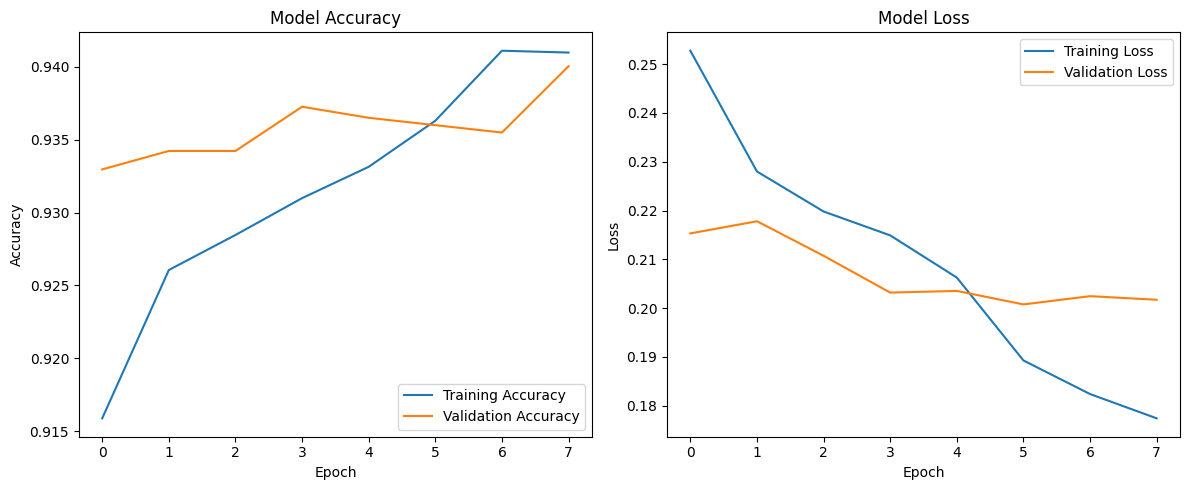

In [24]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



# Prediction

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class_from_path(image_path, model, label_encoder, img_size=(224, 224)):
    try:
        # 1. قراءة الصورة
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(" الصورة غير موجودة أو غير قابلة للقراءة")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, img_size)
        image_normalized = image_resized.astype(np.float32) / 255.0
        image_input = np.expand_dims(image_normalized, axis=0)  # شكل (1, height, width, 3)

        # 2. توقع الكلاس
        prediction = model.predict(image_input)
        predicted_index = np.argmax(prediction, axis=1)[0]

        # 3. فك الترميز للحصول على اسم الكلاس
        predicted_class_name = label_encoder.inverse_transform([predicted_index])[0]

        # 4. عرض الصورة
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {predicted_class_name}", fontsize=14)
        plt.axis('off')
        plt.show()

        return predicted_class_name

    except Exception as e:
        print(f" حصل خطأ أثناء التوقع: {e}")
        return None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


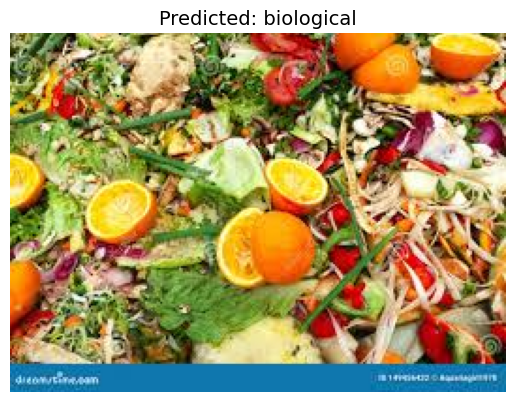

'biological'

In [32]:
predict_class_from_path("/kaggle/input/999999/images.jpeg", model, le)

In [33]:
model.save("/kaggle/working/my_model.h5")